Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.4625 - val_loss: 0.2387
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3028 - val_loss: 0.1263
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1758 - val_loss: 0.0459
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0418 - val_loss: 0.0297
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0260 - val_loss: 0.0718
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0520 - val_loss: 0.0446
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0278 - val_loss: 0.0238
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0223 - val_loss: 0.0209
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0226 - val_loss: 0.0201
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0248 - val_loss: 0.0204
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0209 - val_loss: 0.0234
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0224 - val_loss: 0.0259
Epoch 13/50


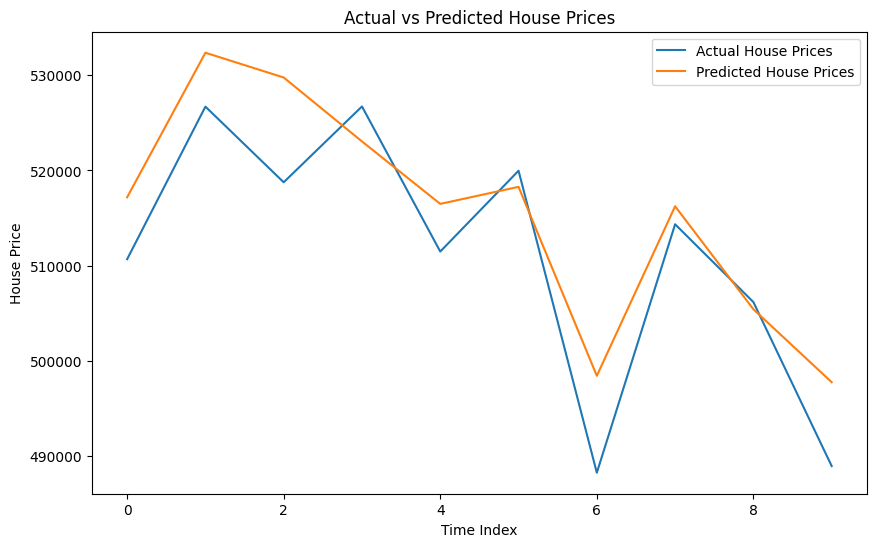

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

df = pd.read_csv('final_df.csv')  # Load data
df['year month'] = pd.to_datetime(df['year month'], format='%Y %b')  # Converting 'year-month' to datetime
df.set_index('year month', inplace=True)  # Setting 'year-month' as index

# Selecting the features and target (avg price is the target)
features = ['sales vol', 'index', 'cpi', 'crime count', 'VIX']
target = 'avg price'

# Extracting feature and target data
data = df[features + [target]].values

# Scaling the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Function to create sequences for LSTM input
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length, :-1])  # Features excluding target (avg price)
        y.append(data[i + sequence_length, -1])  # Target (avg price)
    return np.array(x), np.array(y)

# Setting the sequence length (how many previous time steps to consider)
sequence_length = 12  # monthly data

# Creating sequences from the scaled data
x, y = create_sequences(data_scaled, sequence_length)

# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# LSTM Model Architecture
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(features)), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=8, validation_data=(x_test, y_test), verbose=1)

# Evaluating the model on the test data
test_loss = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")

# Making predictions
y_pred = model.predict(x_test)

# Inverse scaling the predicted and actual values
y_test_inv = scaler.inverse_transform(np.concatenate((x_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_inv = scaler.inverse_transform(np.concatenate((x_test[:, -1, :], y_pred), axis=1))[:, -1]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual House Prices')
plt.plot(y_pred_inv, label='Predicted House Prices')
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('House Price')
plt.title('Actual vs Predicted House Prices')
plt.show()